# Wikipedia Mining

- Identify 5 categories of pages on wikipedia, for each category choose 300 items.

With a python script:
- load the pages,
- preprocess them (*)
- insert them in a dataframe (save the dataframe in a CSV file and use it later for subsequent loads)
- Create statistics (frequency and word length, for example) on the pages and show them with different types of visualization
- Calculate the distance between pages in the same category and between different categories
- Classify the pages, using the categories as labels.
- Check the wikipedia categorization or any deviations with a clustering method and in this case analyze the probable causes

In [1]:
# download the nltk libraries
import nltk
from nltk import word_tokenize, download
from nltk.corpus import stopwords
from nltk.stem.porter import * 

download("punkt")  
download("stopwords")  
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import urllib.request  
from bs4 import BeautifulSoup  

# import the sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import distance
import scipy.stats

import copy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from __future__ import unicode_literals
import sys
import os
import random
import re
import string

from gensim.models import Word2Vec
import seaborn as sns



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 5 Categories 

1. Human activities 
2. Health
3. Physical sciences 
4. Religion 
5. Geography


## Load the pages for the 5 categories

In [40]:
# all categories
categories = ["Human-activities","Health", "Physical-sciences", "Religion", "Geography"]

# URLs of the categories
url_human_activities = "https://petscan.wmflabs.org/?sitelinks_yes=&larger=&regexp_filter=&labels_yes=&smaller=&outlinks_any=&search_wiki=&pagepile=&labels_any=&edits%5Bbots%5D=both&min_redlink_count=1&show_redirects=both&templates_yes=&wikidata_item=no&cb_labels_no_l=1&project=wikipedia&ores_prediction=any&manual_list_wiki=&labels_no=&links_to_no=&search_max_results=500&subpage_filter=either&maxlinks=&sparql=&cb_labels_any_l=1&categories=Human+activities&namespace_conversion=keep&active_tab=tab_categories&show_disambiguation_pages=both&ores_type=any&ns%5B0%5D=1&common_wiki=auto&cb_labels_yes_l=1&outlinks_no=&show_soft_redirects=both&language=en&depth=1&wikidata_source_sites=&page_image=any&referrer_name=&langs_labels_any=&interface_language=en&max_sitelink_count=&doit="
url_health = "https://petscan.wmflabs.org/?show_soft_redirects=both&sitelinks_no=&search_filter=&interface_language=en&sitelinks_any=&regexp_filter=&cb_labels_yes_l=1&project=wikipedia&labels_no=&templates_any=&after=&search_max_results=500&format=html&referrer_name=&ores_prob_to=&manual_list=&outlinks_yes=&wikidata_label_language=&search_wiki=&show_disambiguation_pages=both&cb_labels_any_l=1&combination=subset&ores_type=any&categories=Health&links_to_all=&max_age=&ores_prediction=any&search_query=&cb_labels_no_l=1&sortorder=ascending&sortby=none&common_wiki_other=&minlinks=&sparql=&labels_any=&outlinks_no=&links_to_no=&since_rev0=&ns%5B0%5D=1&depth=1&labels_yes=&language=en&doit="
url_physical_sciences = "https://petscan.wmflabs.org/?outlinks_any=&links_to_all=&search_max_results=500&common_wiki_other=&project=wikipedia&ores_prediction=any&manual_list=&cb_labels_yes_l=1&subpage_filter=either&templates_yes=&langs_labels_no=&regexp_filter=&since_rev0=&outlinks_yes=&language=en&cb_labels_no_l=1&sparql=&ns%5B0%5D=1&depth=1&cb_labels_any_l=1&categories=Physical+sciences&wikidata_source_sites=&interface_language=en&max_sitelink_count=&doit="
url_religion = "https://petscan.wmflabs.org/?outlinks_yes=&langs_labels_yes=&search_wiki=&labels_any=&interface_language=en&manual_list=&referrer_url=&depth=1&ores_prob_from=&smaller=&before=&show_redirects=both&ns%5B0%5D=1&sortby=none&project=wikipedia&search_max_results=500&categories=religion&source_combination=&negcats=&max_age=&edits%5Bbots%5D=both&wikidata_source_sites=&common_wiki=auto&maxlinks=&links_to_no=&cb_labels_yes_l=1&search_filter=&output_limit=&min_sitelink_count=&search_query=&active_tab=tab_categories&namespace_conversion=keep&ores_type=any&wikidata_prop_item_use=&cb_labels_no_l=1&min_redlink_count=1&language=en&format=html&cb_labels_any_l=1&minlinks=&edits%5Bflagged%5D=both&doit="
url_geography = "https://petscan.wmflabs.org/?cb_labels_yes_l=1&referrer_name=&manual_list_wiki=&wikidata_prop_item_use=&search_filter=&larger=&templates_any=&wpiu=any&wikidata_source_sites=&show_disambiguation_pages=both&outlinks_no=&after=&minlinks=&ores_prediction=any&sitelinks_no=&referrer_url=&common_wiki_other=&ores_prob_from=&common_wiki=auto&categories=geography&cb_labels_any_l=1&since_rev0=&wikidata_label_language=&cb_labels_no_l=1&pagepile=&interface_language=en&ns%5B0%5D=1&maxlinks=&labels_yes=&depth=1&format=html&language=en&links_to_no=&smaller=&manual_list=&project=wikipedia&wikidata_item=no&search_query=&combination=subset&search_max_results=500&source_combination=&min_redlink_count=1&doit="

list_urls = [url_human_activities,url_health,url_physical_sciences, url_religion, url_geography]

## Extract the article names from the pages

In [3]:
# Get all the names of the articles for each category
list_raw_tokens = []
for i in list_urls:
    # read the html text only, at given url
    html_doc = urllib.request.urlopen(i).read().decode('utf8')

    # Use BeautifulSoup to parse HTML (build the DOM) and extract text sections from it
    soup = BeautifulSoup(html_doc, 'html.parser')

    # Strip down from DOM unwanted sections (script and style tags)
    for unwanted in soup(["script", "style"]):
        unwanted.extract()  # remove script and style contents from html

    text = soup.get_text()  # extract text from HTML

    K = " "

    for ele in text:
        if ele.isdigit():
            text = text.replace(ele, K)

    lines = []
    for line in text.splitlines():  # for each line into the document
        stripped_line = line.strip()  # remove heading and trailing whitespaces

        # stop at Notes or Citation section of wikipedia pages
        if stripped_line.startswith("Notes") or stripped_line.startswith("Citation"):
            break
        elif stripped_line != "":
            lines.append(stripped_line)


    text = "\n".join(lines)  # rebuild text with blank lines and unwanted section stripped down
    #raw_tokens = word_tokenize(text)
    list_raw_tokens.append(word_tokenize(text))


## Load the wikipedia pages with the article names

In [4]:
# This may take a while
# Get the text of the articles for each category
data = []
category = []
articles = []
i = 0
count = 0
# for each category
for k in range(0, 5):
    while count < 300:
        i += 1
        if list_raw_tokens[k][i] == "Article":
            count += 1

            # get the whole article names
            for j in range(1, 10):
                if list_raw_tokens[k][i+j] != "Article":
                    articles.append(str(list_raw_tokens[k][i+j]))
                else: break

            # get article text
            try:
                # get the url of the article
                url2 = "https://en.wikipedia.org/wiki/" + '_'.join(str(e) for e in articles)
                # read the html text only, at given url
                html_doc = urllib.request.urlopen(url2).read().decode("utf8", "ignore")
                soup = BeautifulSoup(html_doc, 'html.parser')
            except:
                # if the article is not found, skip it
                articles.clear()
                count -= 1
                continue

            # Strip down from unwanted sections 
            for unwanted in soup(["script", "style"]):
                unwanted.extract()  

            # extract text from HTML
            text = soup.get_text() 

            # remove heading and trailing whitespaces
            lines = []
            for line in text.splitlines():  
                stripped_line = line.strip()

                # stop at Notes or Citation section of wikipedia pages
                if stripped_line.startswith("Notes") or stripped_line.startswith("Citation"):
                    break
                elif stripped_line != "":
                    lines.append(stripped_line)

            # rebuild text 
            text = "\n".join(lines)  
            category.append(text)
            articles.clear()

    # get the text for each category
    data.append(copy.deepcopy(category))

    # reset parameters
    category.clear()
    count = 0
    i = 0

## Create a dataframe

In [5]:
# Create the pandas DataFrame
df = pd.DataFrame(data, categories)

# Transpose the DataFrame
df = df.transpose()

# display the DataFrame
df

,Human-activities,Health,Physical-sciences,Religion,Geography
0,"Art - Wikipedia\nArt\nFrom Wikipedia, the free...",Beryllium - Wikipedia\nBeryllium\nFrom Wikiped...,"Atom - Wikipedia\nAtom\nFrom Wikipedia, the fr...",Afterlife - Wikipedia\nAfterlife\nFrom Wikiped...,List of explorations - Wikipedia\nList of expl...
1,Abiotic stress - Wikipedia\nAbiotic stress\nFr...,"Condom - Wikipedia\nCondom\nFrom Wikipedia, th...","Alloy - Wikipedia\nAlloy\nFrom Wikipedia, the ...","Animism - Wikipedia\nAnimism\nFrom Wikipedia, ...","Furlong - Wikipedia\nFurlong\nFrom Wikipedia, ..."
2,Affection - Wikipedia\nAffection\nFrom Wikiped...,Chlorine - Wikipedia\nChlorine\nFrom Wikipedia...,Allotropy - Wikipedia\nAllotropy\nFrom Wikiped...,Anthroposophy - Wikipedia\nAnthroposophy\nFrom...,Far East - Wikipedia\nFar East\nFrom Wikipedia...
3,"Barter - Wikipedia\nBarter\nFrom Wikipedia, th...",Chromium - Wikipedia\nChromium\nFrom Wikipedia...,Analytical chemistry - Wikipedia\nAnalytical c...,Absolute Infinite - Wikipedia\nAbsolute Infini...,Greenwich Mean Time - Wikipedia\nGreenwich Mea...
4,Communication - Wikipedia\nCommunication\nFrom...,"Cadmium - Wikipedia\nCadmium\nFrom Wikipedia, ...",Chemistry - Wikipedia\nChemistry\nFrom Wikiped...,Casuistry - Wikipedia\nCasuistry\nFrom Wikiped...,Longitude - Wikipedia\nLongitude\nFrom Wikiped...
...,...,...,...,...,...
295,Position line - Wikipedia\nPosition line\nFrom...,Condom fatigue - Wikipedia\nCondom fatigue\nFr...,Incipient wetness impregnation - Wikipedia\nIn...,The Holy Science - Wikipedia\nThe Holy Science...,Public open space - Wikipedia\nPublic open spa...
296,Position circle - Wikipedia\nPosition circle\n...,List of R-phrases - Wikipedia\nList of R-phras...,Chemical technologist - Wikipedia\nChemical te...,Spiritual intelligence - Wikipedia\nSpiritual ...,List of countries by northernmost point - Wiki...
297,Sector light - Wikipedia\nSector light\nFrom W...,List of S-phrases - Wikipedia\nList of S-phras...,Congruent melting - Wikipedia\nCongruent melti...,Blackfriars Road - Wikipedia\nBlackfriars Road...,Western Australian borders - Wikipedia\nWester...
298,Light characteristic - Wikipedia\nLight charac...,"Dry sex - Wikipedia\nDry sex\nFrom Wikipedia, ...",Marsquake - Wikipedia\nMarsquake\nFrom Wikiped...,Millenarianism in colonial societies - Wikiped...,Krasnoyarsk Time - Wikipedia\nKrasnoyarsk Time...


## Save the dataframe in a CSV file

In [28]:
# Save the DataFrame to a csv file
files = [f for f in os.listdir('C:/Users/ewieh/Documents/Semester 5/Massive_Data/Wikipedia_Project')]
if not 'Wikipedia_Mining_Data.csv' in files: df.to_csv('Wikipedia_Mining_Data.csv')

# Start from here if you have already saved the dataframe

In [41]:
# open file Wikipedia_Mining.csv as a dataframe
df = pd.read_csv('Wikipedia_Mining_Data.csv', sep=',', header=None)
categories = ["Human-activities","Health", "Physical-sciences", "Religion", "Geography"]

## Preprocess the dataframe

In [42]:
# drop first column because it is empty
df = df.drop(df.columns[0], axis=1)

# rename the columns
df.columns = categories

# drop the first row because it is redundant
df = df.drop(df.index[0])

# preprocess the articles by removing punctuation, numbers, and special characters
df = df.replace(r'[^a-zA-Z ]+', ' ', regex=True)

# convert all characters to lowercase
df = df.apply(lambda x: x.astype(str).str.lower())

# lemmatize the words
lemmatizer = WordNetLemmatizer()
df = df.apply(lambda x: x.astype(str).str.split().apply(lambda x: [lemmatizer.lemmatize(item) for item in x]).str.join(' '))

# remove stop words
stop_words = set(stopwords.words('english'))
stop_words.add('wikipedia')
df = df.apply(lambda x: x.astype(str).str.split().apply(lambda x: [item for item in x if item not in stop_words]).str.join(' '))

# tokenize the words
df = df.apply(lambda x: x.astype(str).str.split()) 
df

,Human-activities,Health,Physical-sciences,Religion,Geography
1,"[art, art, free, encyclopedia, jump, navigatio...","[beryllium, beryllium, free, encyclopedia, jum...","[atom, atom, free, encyclopedia, jump, navigat...","[afterlife, afterlife, free, encyclopedia, jum...","[list, exploration, list, exploration, free, e..."
2,"[abiotic, stress, abiotic, stress, free, encyc...","[condom, condom, free, encyclopedia, jump, nav...","[alloy, alloy, free, encyclopedia, jump, navig...","[animism, animism, free, encyclopedia, jump, n...","[furlong, furlong, free, encyclopedia, jump, n..."
3,"[affection, affection, free, encyclopedia, jum...","[chlorine, chlorine, free, encyclopedia, jump,...","[allotropy, allotropy, free, encyclopedia, jum...","[anthroposophy, anthroposophy, free, encyclope...","[far, east, far, east, free, encyclopedia, jum..."
4,"[barter, barter, free, encyclopedia, jump, nav...","[chromium, chromium, free, encyclopedia, jump,...","[analytical, chemistry, analytical, chemistry,...","[absolute, infinite, absolute, infinite, free,...","[greenwich, mean, time, greenwich, mean, time,..."
5,"[communication, communication, free, encyclope...","[cadmium, cadmium, free, encyclopedia, jump, n...","[chemistry, chemistry, free, encyclopedia, jum...","[casuistry, casuistry, free, encyclopedia, jum...","[longitude, longitude, free, encyclopedia, jum..."
...,...,...,...,...,...
296,"[position, line, position, line, free, encyclo...","[condom, fatigue, condom, fatigue, free, encyc...","[incipient, wetness, impregnation, incipient, ...","[numinous, numinous, free, encyclopedia, jump,...","[list, country, northernmost, point, list, cou..."
297,"[position, circle, position, circle, free, enc...","[list, r, phrase, list, r, phrase, free, encyc...","[chemical, technologist, chemical, technologis...","[holy, science, holy, science, free, encyclope...","[western, australian, border, western, austral..."
298,"[sector, light, sector, light, free, encyclope...","[list, phrase, list, phrase, free, encyclopedi...","[congruent, melting, congruent, melting, free,...","[spiritual, intelligence, spiritual, intellige...","[krasnoyarsk, time, krasnoyarsk, time, free, e..."
299,"[light, characteristic, light, characteristic,...","[dry, sex, dry, sex, free, encyclopedia, jump,...","[marsquake, marsquake, free, encyclopedia, jum...","[blackfriar, road, blackfriar, road, free, enc...","[list, sovereign, state, dependent, territory,..."


## Create statistics on the pages
### (frequency and word length, for example) 

In [43]:
# calculacte the number of words in each article and store them in a new column called "word_count" for each category
for i in categories:
    df[i + '_word_count'] = df[i].apply(lambda x: len(x))

# calculate the number of unique words in each article and store them in a new column called "unique_word_count" for each category
for i in categories:
    df[i + '_unique_word_count'] = df[i].apply(lambda x: len(set(x)))

# calculate the frequency of each word in each article and store them in a new column called "word_frequency" for each category
for i in categories:
    df[i + '_word_frequency'] = df[i].apply(lambda x: Counter(x))

# calculate the lenght of each word in each article and store them in a new column called "word_lenght" for each category
for i in categories:
    df[i + '_word_length'] = df[i].apply(lambda x: [len(word) for word in x])
    
# calculate the average lenght of each word in each article and store them in a new column called "average_word_lenght" for each category
for i in categories:
    df[i + '_average_word_length'] = df[i + '_word_length'].apply(lambda x: sum(x)/len(x))

# calculate the most common words in each article and store them in a new column called "word_lenght" for each category
for i in categories:
    df[i + '_most_common_words'] = df[i].apply(lambda x: Counter(x).most_common(10))
df

,Human-activities,Health,Physical-sciences,Religion,Geography,Human-activities_word_count,Health_word_count,Physical-sciences_word_count,Religion_word_count,Geography_word_count,...,Human-activities_average_word_length,Health_average_word_length,Physical-sciences_average_word_length,Religion_average_word_length,Geography_average_word_length,Human-activities_most_common_words,Health_most_common_words,Physical-sciences_most_common_words,Religion_most_common_words,Geography_most_common_words
1,"[art, art, free, encyclopedia, jump, navigatio...","[beryllium, beryllium, free, encyclopedia, jum...","[atom, atom, free, encyclopedia, jump, navigat...","[afterlife, afterlife, free, encyclopedia, jum...","[list, exploration, list, exploration, free, e...",5382,6893,5325,7165,567,...,6.538833,6.341651,6.479812,6.385764,6.386243,"[(art, 331), (work, 57), (artist, 37), (centur...","[(beryllium, 308), (archived, 68), (original, ...","[(atom, 176), (electron, 139), (nucleus, 97), ...","[(soul, 99), (death, 74), (afterlife, 69), (li...","[(america, 12), (exploration, 10), (north, 10)..."
2,"[abiotic, stress, abiotic, stress, free, encyc...","[condom, condom, free, encyclopedia, jump, nav...","[alloy, alloy, free, encyclopedia, jump, navig...","[animism, animism, free, encyclopedia, jump, n...","[furlong, furlong, free, encyclopedia, jump, n...",2938,8970,3648,7054,1611,...,6.717835,6.504571,6.493969,6.820386,5.947858,"[(plant, 101), (stress, 94), (abiotic, 56), (s...","[(condom, 496), (use, 126), (archived, 111), (...","[(alloy, 128), (steel, 91), (iron, 73), (metal...","[(animism, 112), (religion, 80), (p, 66), (har...","[(furlong, 60), (foot, 46), (unit, 31), (mile,..."
3,"[affection, affection, free, encyclopedia, jum...","[chlorine, chlorine, free, encyclopedia, jump,...","[allotropy, allotropy, free, encyclopedia, jum...","[anthroposophy, anthroposophy, free, encyclope...","[far, east, far, east, free, encyclopedia, jum...",1200,9307,1083,7112,2293,...,7.321667,6.480606,6.479224,6.982565,6.761012,"[(affection, 38), (emotion, 15), (love, 11), (...","[(chlorine, 287), (chloride, 112), (cl, 109), ...","[(allotrope, 32), (form, 27), (element, 26), (...","[(steiner, 175), (spiritual, 87), (anthroposop...","[(east, 91), (asia, 54), (far, 53), (language,..."
4,"[barter, barter, free, encyclopedia, jump, nav...","[chromium, chromium, free, encyclopedia, jump,...","[analytical, chemistry, analytical, chemistry,...","[absolute, infinite, absolute, infinite, free,...","[greenwich, mean, time, greenwich, mean, time,...",3795,4825,3204,425,1171,...,6.663768,6.452435,7.274969,6.616471,6.003416,"[(barter, 109), (exchange, 69), (trade, 40), (...","[(chromium, 295), (cr, 72), (iii, 50), (used, ...","[(chemistry, 104), (analysis, 64), (analytical...","[(set, 18), (number, 12), (absolute, 8), (infi...","[(time, 122), (greenwich, 41), (gmt, 36), (mea..."
5,"[communication, communication, free, encyclope...","[cadmium, cadmium, free, encyclopedia, jump, n...","[chemistry, chemistry, free, encyclopedia, jum...","[casuistry, casuistry, free, encyclopedia, jum...","[longitude, longitude, free, encyclopedia, jum...",6244,5178,6294,2621,3515,...,7.301249,6.170722,6.864474,6.571156,6.610811,"[(communication, 328), (message, 59), (model, ...","[(cadmium, 274), (cd, 51), (metal, 44), (doi, ...","[(chemistry, 207), (chemical, 164), (substance...","[(casuistry, 87), (ethic, 76), (doi, 53), (mor...","[(time, 107), (longitude, 90), (latitude, 32),..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,"[position, line, position, line, free, encyclo...","[condom, fatigue, condom, fatigue, free, encyc...","[incipient, wetness, impregnation, incipient, ...","[numinous, numinous, free, encyclopedia, jump,...","[list, country, northernmost, point, list, cou...",253,777,234,1300,1403,...,6.988142,5.976834,7.299145,6.555385,5.461155,"[(line, 16), (position, 10), (article, 6), (na...","[(condom, 44), (fatigue, 22), (men, 22), (use,...","

## Show them with different types of visualization

<AxesSubplot:title={'center':'Unique Word Count for each category'}, ylabel='Frequency'>

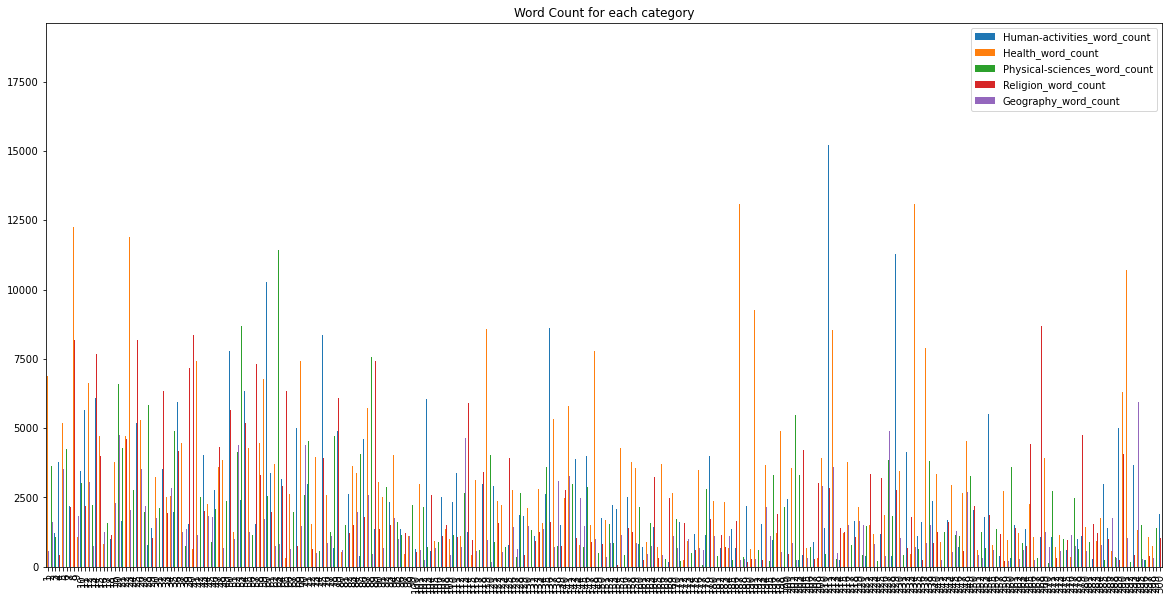

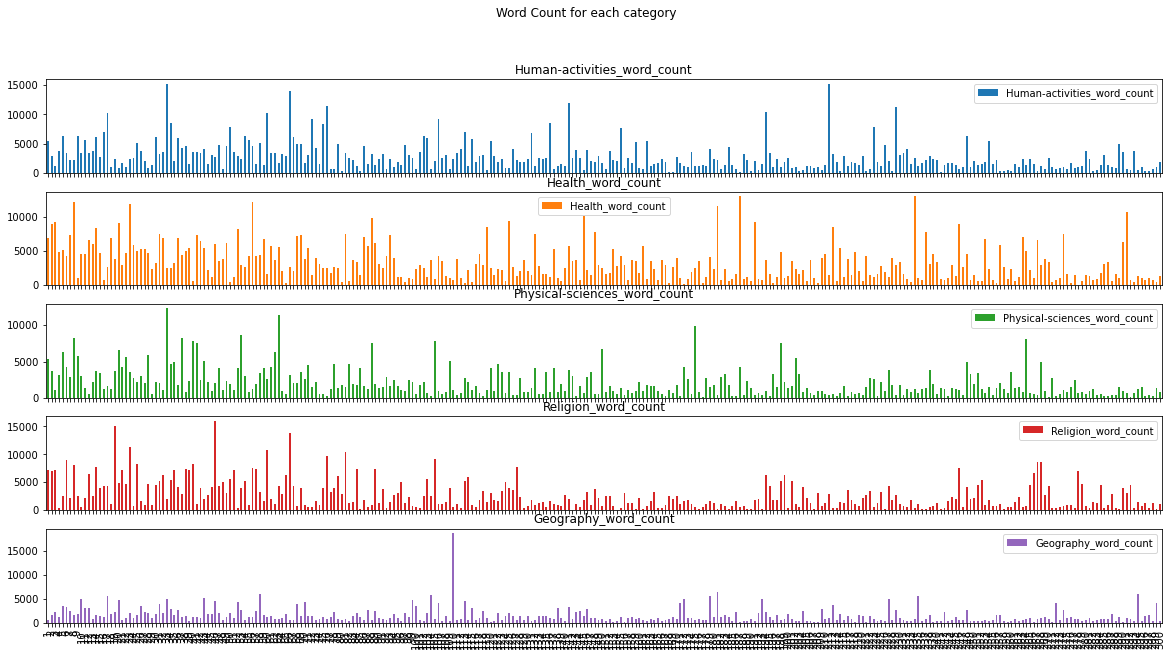

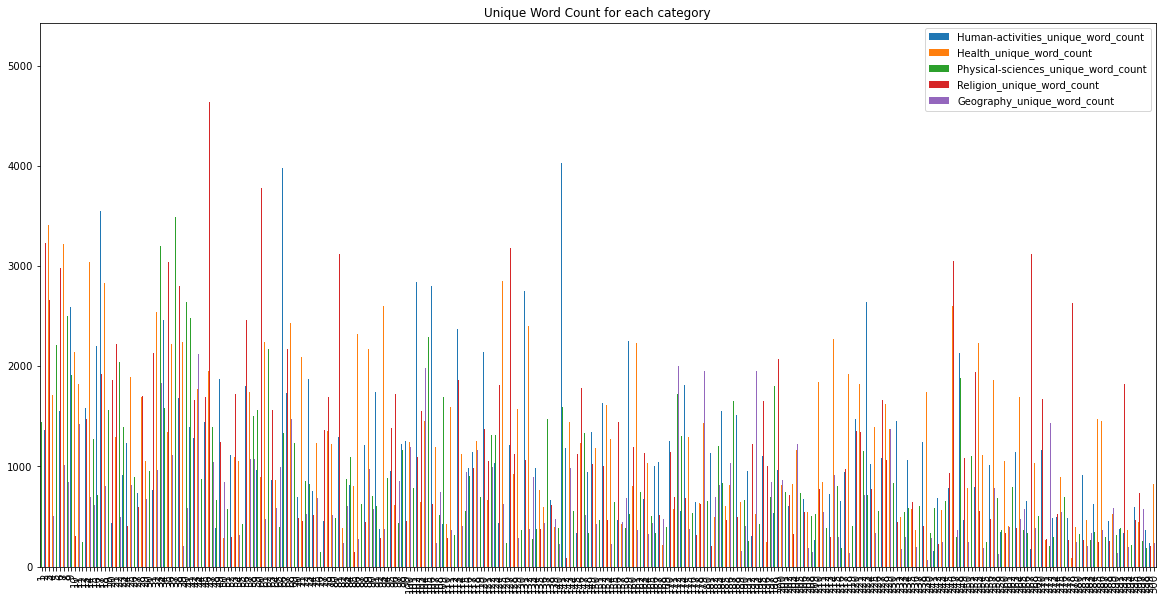

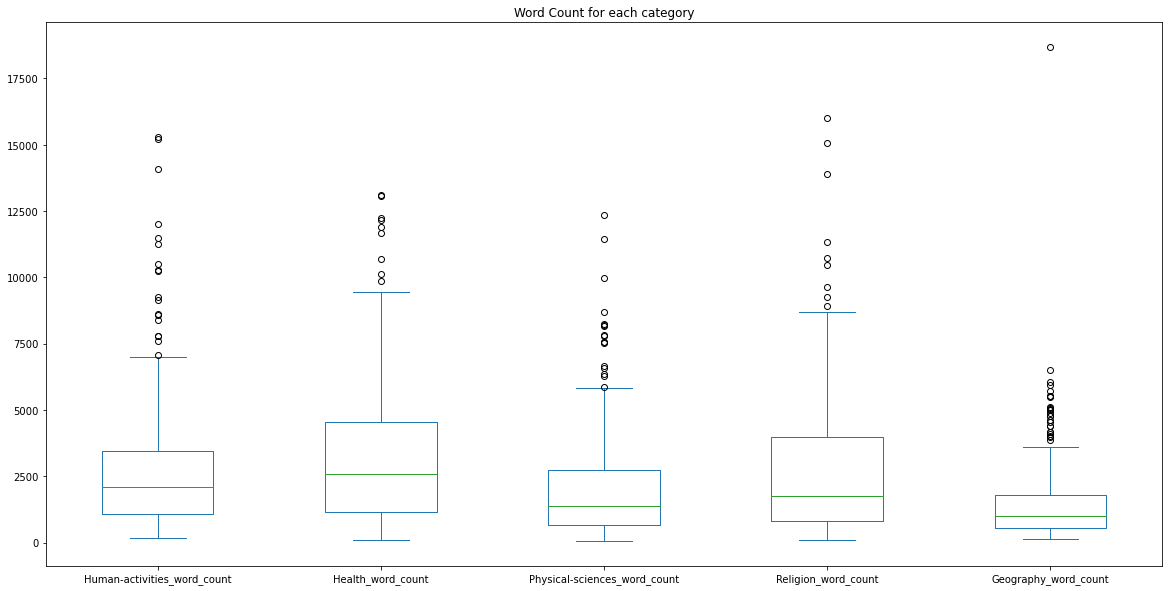

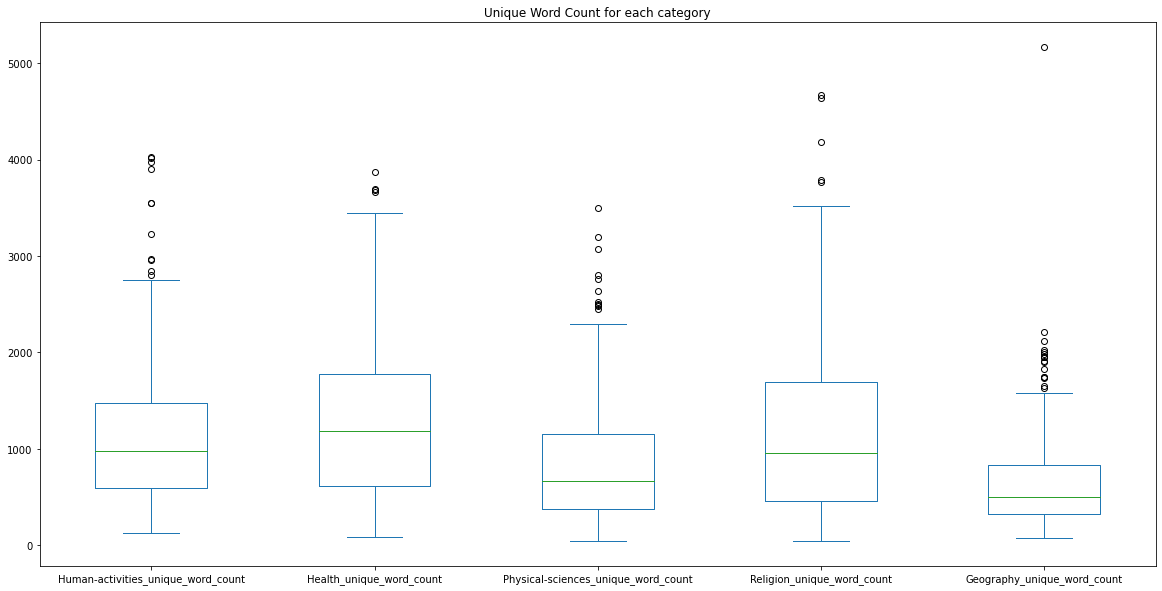

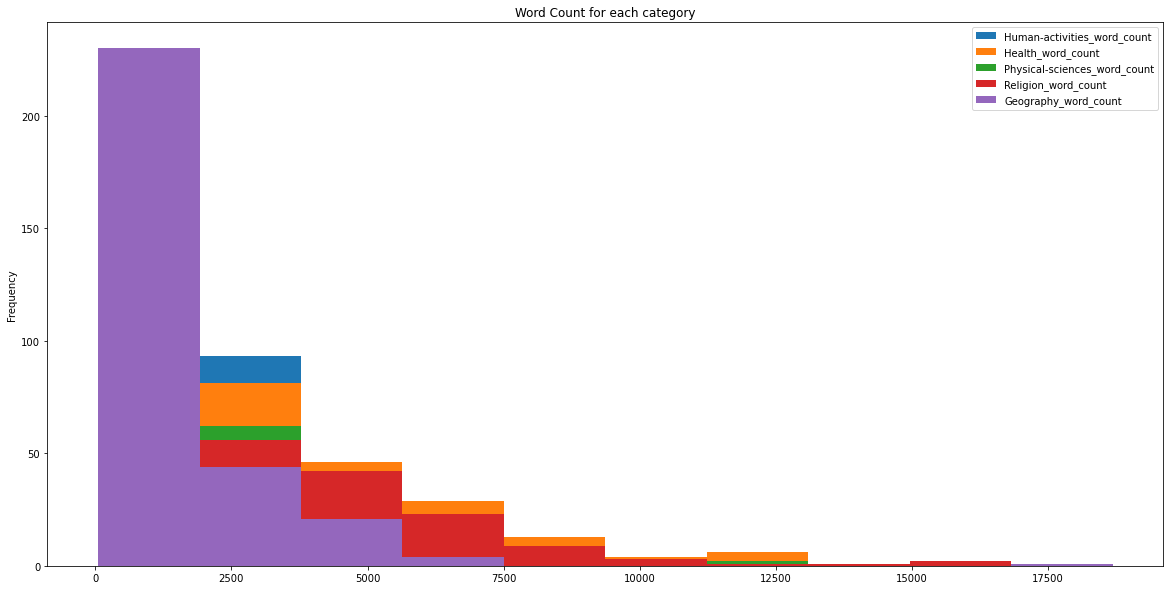

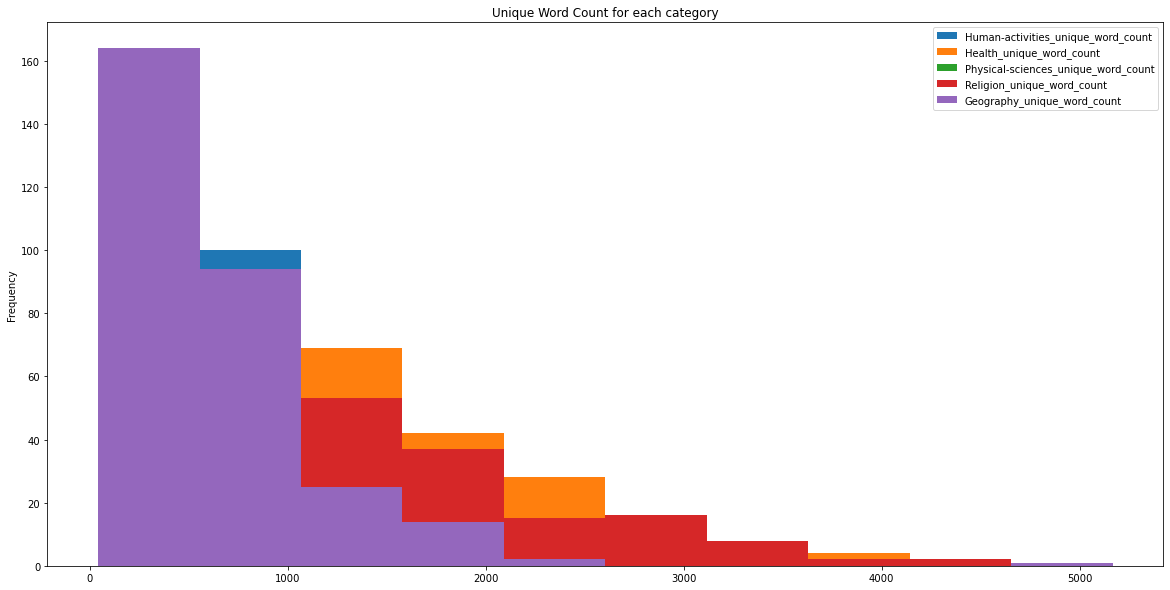

In [44]:
# Visualize the columns word count for each category in a bar chart
df.plot.bar(y=[i + '_word_count' for i in categories], figsize=(20, 10), title='Word Count for each category')

# Visualize the average word count for each category in a bar chart so you have one graph for each category and not one graph for every article
df.plot.bar(y=[i + '_word_count' for i in categories], figsize=(20, 10), title='Word Count for each category', subplots=True)

# Visualize the columns unique word count for each category in a bar chart
df.plot.bar(y=[i + '_unique_word_count' for i in categories], figsize=(20, 10), title='Unique Word Count for each category')

# Visualize the word count for each category in a box plot
df[[i + '_word_count' for i in categories]].plot.box(figsize=(20, 10), title='Word Count for each category')

# Visualize the unique word count for each category in a box plot
df[[i + '_unique_word_count' for i in categories]].plot.box(figsize=(20, 10), title='Unique Word Count for each category')

# Visualize the word count for each category in a histogram
df[[i + '_word_count' for i in categories]].plot.hist(figsize=(20, 10), title='Word Count for each category')

# Visualize the unique word count for each category in a histogram
df[[i + '_unique_word_count' for i in categories]].plot.hist(figsize=(20, 10), title='Unique Word Count for each category')

## Interpretation of the graphs:
Human activities is the highest in frequency, unique words and word length, followed by health, physical sciences, religion and geography.
Health is the lowest in frequency, unique words and word length, followed by geography, religion, physical sciences and human activities.

## Calculate the distance between pages in the same category

In [45]:
# if df is tokenized then join the words back together
if type(df.iloc[0, 0]) == list:
    for i in categories:
        df[i] = df[i].apply(lambda x: ' '.join(x))

In [46]:
statistics = []
vectorizer = CountVectorizer(analyzer='word')
# do the job
for i in categories:
    X = vectorizer.fit_transform(df[i])

    # build TfIdf of vectorized documents
    tfidf = TfidfTransformer()
    X_t = tfidf.fit_transform(X)
            
    # do the job
    X = vectorizer.fit_transform(df[i])

    # selecting a small subset of document frequency vector
    sub_X = X.toarray()

    # compute distance matrix for the selected subset using cosine distance metric
    dm_cos = distance.cdist(sub_X, sub_X, "cosine")
    dm_jaccard = distance.cdist(sub_X, sub_X, "jaccard")

    # append the statistics to the statistics list
    statistics.append([dm_cos.min(), dm_cos.mean(), np.median(dm_cos), dm_cos.max(), dm_jaccard.min(), dm_jaccard.mean(), np.median(dm_jaccard), dm_jaccard.max()])

# create a new df with the statistics
statistics_df = pd.DataFrame(statistics, columns=['min', 'mean', 'median', 'max', 'min_jaccard', 'mean_jaccard', 'median_jaccard', 'max_jaccard'], index=categories)
statistics_df

,min,mean,median,max,min_jaccard,mean_jaccard,median_jaccard,max_jaccard
Human-activities,0.0,0.884301,0.897895,0.994349,0.0,0.940534,0.949968,0.997007
Health,0.0,0.856192,0.876449,0.988698,0.0,0.940127,0.946300,0.998104
Physical-sciences,0.0,0.862790,0.883940,0.994816,0.0,0.924027,0.936073,0.998806
Religion,0.0,0.827917,0.847159,0.991534,0.0,0.947270,0.962111,0.999665
Geography,0.0,0.871917,0.898787,0.999133,0.0,0.918840,0.934708,0.999035


### Interpretation

Generally, the categories have a mean higher than 0.81, which means that the distance between the pages is high.
The category with the highest mean is human activities, followed by health, physical sciences, religion and geography.

tfidf is a count of the number of times a word appears in a document, divided by the total number of words in the document. This is done for every document in the corpus. The words that appear most frequently across all documents are given a lower weight, whereas those that appear less frequently are given a higher weight.

## Calculate the distance between pages between different categories


In [47]:
# prepare the data for the model
# transform the dataframe df so that the shape is (articles, corresponding categories)
df = df.T.stack().reset_index()
# drop rows after the first 1500
df = df.drop(df.index[1500:])
# rename the columns
df.columns = ['label', 'category', 'text']
# drop the category column
df = df.drop(columns=['category'])
df

,label,text
0,Human-activities,art art free encyclopedia jump navigation jump...
1,Human-activities,abiotic stress abiotic stress free encyclopedi...
2,Human-activities,affection affection free encyclopedia jump nav...
3,Human-activities,barter barter free encyclopedia jump navigatio...
4,Human-activities,communication communication free encyclopedia ...
...,...,...
1495,Geography,list country northernmost point list country n...
1496,Geography,western australian border western australian b...
1497,Geography,krasnoyarsk time krasnoyarsk time free encyclo...
1498,Geography,list sovereign state dependent territory list ...


In [48]:
statistics = []
cat = []
for i in categories: 
    for j in categories:
        if i > j:
            # group by category i and j in a new df
            df_grouped = df[df['label'].isin([i, j])]

            X = vectorizer.fit_transform(df_grouped['text'])

            # build TfIdf of vectorized documents
            tfidf = TfidfTransformer()
            X_t = tfidf.fit_transform(X)

            # selecting a small subset of document frequency vector
            sub_X = X[:300].toarray()
            sub_Y = X[300:].toarray()

            # compute distance matrix for the selected subset using cosine distance metric
            dm = distance.cdist(sub_X, sub_Y, "cosine")

            # print(np.where(dm == dm.min()))
            statistics.append([dm.min(), dm.mean(), np.median(dm), dm.max()])
            cat.append(i + ' - ' + j)

# create a new df with the statistics
statistics_diff_df = pd.DataFrame(statistics, columns=['min', 'mean', 'median', 'max'], index=cat)
statistics_diff_df


,min,mean,median,max
Human-activities - Health,0.000000,0.902728,0.908819,0.996903
Human-activities - Geography,0.000000,0.901098,0.909225,0.999718
Health - Geography,0.276381,0.910807,0.916392,0.999059
Physical-sciences - Human-activities,0.000000,0.909134,0.915948,0.995068
Physical-sciences - Health,0.153402,0.907700,0.913473,0.996903
Physical-sciences - Geography,0.000000,0.907089,0.915894,0.999578
Religion - Human-activities,0.000000,0.887961,0.894845,0.996960
Religion - Health,0.385106,0.903899,0.909833,0.990880
Religion - Physical-sciences,0.000000,0.909556,0.917197,0.996960
Religion - Geography,0.208640,0.896222,0.905143,0.998932


## Classify the pages, using the categories as labels

In [49]:
# store the feature matrix (X) and response vector (y)
count_vect = CountVectorizer()  # check documentation for stop_words

X_train_counts = count_vect.fit_transform(df['text'])

X = X_train_counts
X = X.toarray()
y = df['label']
  
# splitting X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [50]:
# training the model on training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
  
# making predictions on the testing set
y_pred = gnb.predict(X_test)
  
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model classification report:")

# print classification report
print(metrics.classification_report(y_test, y_pred))

Gaussian Naive Bayes model classification report:
                   precision    recall  f1-score   support

        Geography       0.80      0.63      0.71       114
           Health       0.74      0.84      0.79       126
 Human-activities       0.65      0.73      0.69       120
Physical-sciences       0.86      0.78      0.82       122
         Religion       0.80      0.82      0.81       118

         accuracy                           0.76       600
        macro avg       0.77      0.76      0.76       600
     weighted avg       0.77      0.76      0.76       600



In [51]:
# Using random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# print classification report
print("Random Forest Classifier model classification report:")
print(metrics.classification_report(y_test, y_pred))


Random Forest Classifier model classification report:
                   precision    recall  f1-score   support

        Geography       0.41      0.87      0.55       114
           Health       0.89      0.73      0.80       126
 Human-activities       0.75      0.25      0.38       120
Physical-sciences       0.81      0.72      0.76       122
         Religion       0.75      0.67      0.71       118

         accuracy                           0.65       600
        macro avg       0.72      0.65      0.64       600
     weighted avg       0.73      0.65      0.64       600



In [52]:
# Using SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# print classification report
print("SVM model classification report:")
print(metrics.classification_report(y_test, y_pred))

SVM model classification report:
                   precision    recall  f1-score   support

        Geography       0.39      0.89      0.54       114
           Health       0.92      0.68      0.79       126
 Human-activities       0.59      0.57      0.58       120
Physical-sciences       0.94      0.53      0.68       122
         Religion       0.92      0.48      0.63       118

         accuracy                           0.63       600
        macro avg       0.75      0.63      0.64       600
     weighted avg       0.76      0.63      0.65       600



In [53]:
# Using KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

# print classification report
print("KNN model classification report:")
print(metrics.classification_report(y_test, y_pred))

KNN model classification report:
                   precision    recall  f1-score   support

        Geography       0.43      0.89      0.58       114
           Health       0.92      0.57      0.71       126
 Human-activities       0.83      0.33      0.48       120
Physical-sciences       0.71      0.78      0.74       122
         Religion       0.78      0.69      0.73       118

         accuracy                           0.65       600
        macro avg       0.73      0.65      0.65       600
     weighted avg       0.74      0.65      0.65       600



### Interpretation of the results: 

The classification is not very good, because the categories are not very well defined. 

For example, the category "Human activities" includes a lot of different topics, such as "Sports", "Music", "Arts", "Literature", "Food", "Fashion", "Games", etc... 

The category "Health" includes a lot of different topics, such as "Diseases", "Medicine", "Healthcare", "Nutrition", "Fitness", "Mental health", etc... 

The category "Physical sciences" includes a lot of different topics, such as "Physics", "Chemistry", "Biology", "Astronomy", "Geology", "Mathematics", etc... 

The category "Religion" includes a lot of different topics, such as "Christianity", "Islam", "Judaism", "Hinduism", "Buddhism", "Sikhism", "Atheism", etc... 

The category "Geography" includes a lot of different topics, such as "Countries", "Cities", "Mountains", "Rivers", "Lakes", "Oceans", "Continents", etc.. 

To improve the classification, we could use a clustering method to group the pages in the same category, and then use the categories as labels.

### Differences between the different classification methods
The Gaussian Naive Bayes method is the best method for this classification, because it has the highest accuracy, precision and recall. 

## Check the wikipedia categorization or any deviations with a clustering method and in this case analyze the probable causes

In [64]:
def kmeans_clusters(X, k, print_silhouette_values):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = KMeans(n_clusters=k).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette Coefficient: {silhouette_score(X, km.labels_):.3f}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]}"
            )
    return km, km.labels_

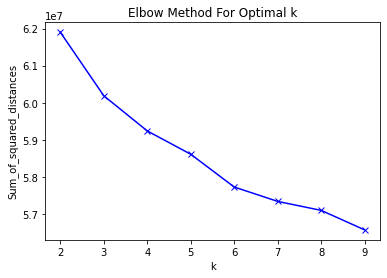

In [55]:
# Elbow method to find the optimal number of clusters
Sum_of_squared_distances = []
K = range(2,10)
X = count_vect.fit_transform(df['text']).toarray()
for k in K:
   # k means using k clusters
   km = KMeans(n_clusters=k).fit(X)
   Sum_of_squared_distances.append(km.inertia_)

# plot the elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
docs = df["text"].values
k = 6
clustering, cluster_labels = kmeans_clusters(X, k,print_silhouette_values=True)
df_clusters = pd.DataFrame({"text": docs,"cluster": cluster_labels})

For n_clusters = 6
Silhouette Coefficient: 0.428
Silhouette values:
    Cluster 0: Size:8
    Cluster 1: Size:149
    Cluster 2: Size:86
    Cluster 3: Size:1
    Cluster 4: Size:15
    Cluster 5: Size:1241


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

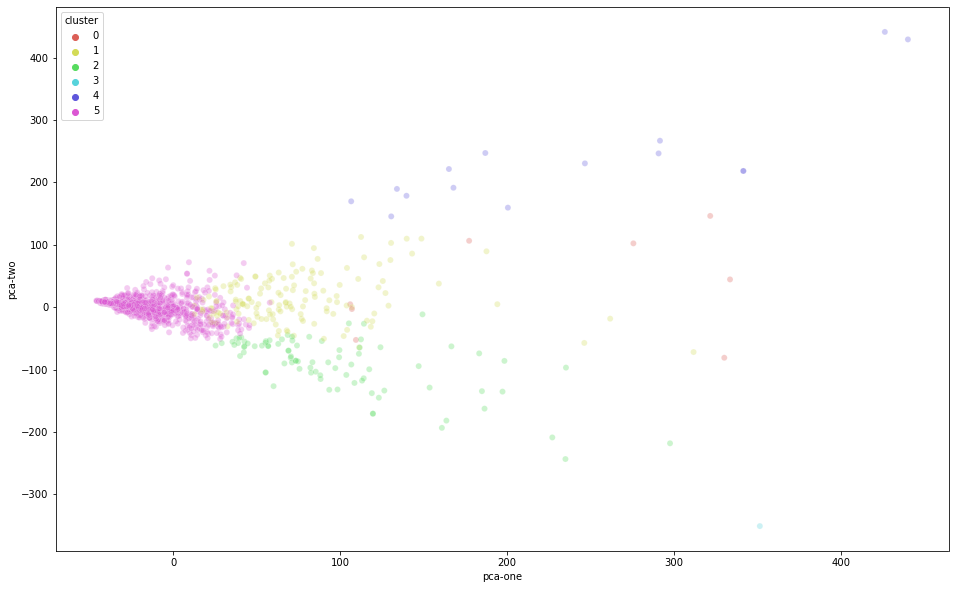

In [66]:
# Visualize the kmeans clusters of documents using PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)
df_pca = pd.DataFrame({
    "pca-one": pca_result[:, 0],
    "pca-two": pca_result[:, 1],
    "cluster": cluster_labels
})
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="cluster",
    palette=sns.color_palette("hls", k),
    data=df_pca,
    legend="full",
    alpha=0.3
)


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

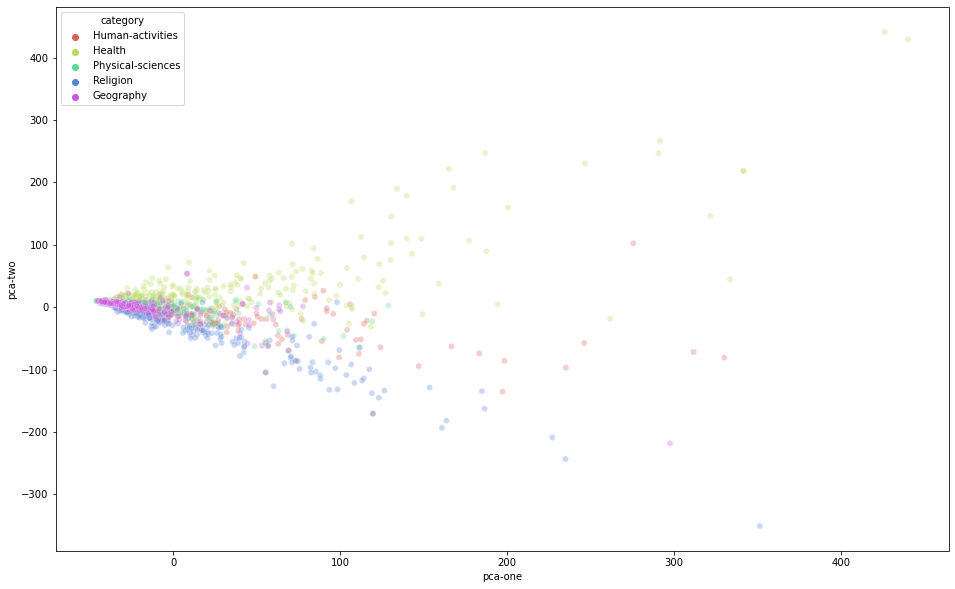

In [67]:
# Visualize the documents of the categories using PCA with 2 components
# x to array

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)
df_pca = pd.DataFrame({
    "pca-one": pca_result[:, 0],
    "pca-two": pca_result[:, 1],
    "category": df["label"]
})
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category",
    palette=sns.color_palette("hls", 5),
    data=df_pca,
    legend="full",
    alpha=0.3
)

### Interpretation of the results: 
Compared to the categories, the clustering method is better, because it groups the pages in the same category.